## Step 3: Postprocessing: analyze fit results

Import some packages, create some folders. <br> Start this script in the target's main directory (workingdir+'/'+sourcetag) from Step 1.

In [53]:
import pickle
import matplotlib.pyplot as pl
import numpy as np
import corner
import os
import matplotlib

#Start from target's main directory from Step 1
os.chdir('/d1/boudica1/lmatra/GJ14')

#Read in directories as defined in step 1
radmcgalapath, casapath, sourcetag, workingdir, vis, nvis = pickle.load(open('./dirvises.npy','rb'))
os.chdir('./uvfit')

for i in ['analysis', 'plots', 'uvfit/evaluation']:
    if not os.path.exists(workingdir+'/'+sourcetag+'/'+i):
        os.mkdir(workingdir+'/'+sourcetag+'/'+i)
!cp -r {radmcgalapath}/utils/maketraceandcornerplot.py {workingdir}/{sourcetag}/uvfit/. 
!cp -r {radmcgalapath}/utils/uvresidualtoms.py {workingdir}/{sourcetag}/uvfit/. 
!cp -r {radmcgalapath}/utils/makeuvdeprojplot_simple_multiple.py {workingdir}/{sourcetag}/uvfit/.
!cp -r {radmcgalapath}/utils/plotimage.py {workingdir}/{sourcetag}/analysis/.  
!cp -r {radmcgalapath}/utils/imagecombo.py {workingdir}/{sourcetag}/analysis/. 

cp: cannot stat `/d1/boudica1/lmatra/radmc-gala/utils/uvresidualtoms.py': No such file or directory
cp: cannot stat `/d1/boudica1/lmatra/radmc-gala/utils/plotimage.py': No such file or directory
cp: cannot stat `/d1/boudica1/lmatra/radmc-gala/utils/imagecombo.py': No such file or directory


Read in results from MCMC visibility fitting through emcee sampler, read from backend as defined in Step 2. 

In [16]:
newbackend=False
postprocessing=True
backendaddress='backend_'+sourcetag+'_todaysdate_computersname.pkl'
pickle.dump(backendaddress, open('backendaddress.npy', 'wb'), protocol=2)
%run -i setup_mcmc

#Read in chain
chain=backend.get_chain()

Setting up sampler...


If necessary, remove some walkers that got stuck in unreasonable regions of parameter space (e.g. if they were accidentally started beyond prior boundaries)

In [3]:
#chain=np.delete(chain, np.where(chain[-1,:,8]<=0.25e-3), axis=1)
#chain=np.delete(chain, np.where(chain[600,:,8]<=0.25e-3), axis=1)
#chain=np.delete(chain, np.where(chain[750,:,8]<=0.25e-3), axs=1)

Decide how long the burn-in phase should be, and what the titles of the plots should be. Produce the plots!

Changing units for plotting
Setting labels for ndim parameters
NB: Code is assuming that you chose the end of burn-in phase correctly.


maketraceandcornerplot.py:107: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.savefig(cornername+'.pdf')
maketraceandcornerplot.py:119: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  pl.savefig(cornername+'_small.pdf')
maketraceandcornerplot.py:119: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  pl.savefig(cornername+'_small.pdf')
/d1/boudica1/anaconda3/lib/python3.7/site-packages/IPython/core/events.py:88: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  func(*args, **kwargs)


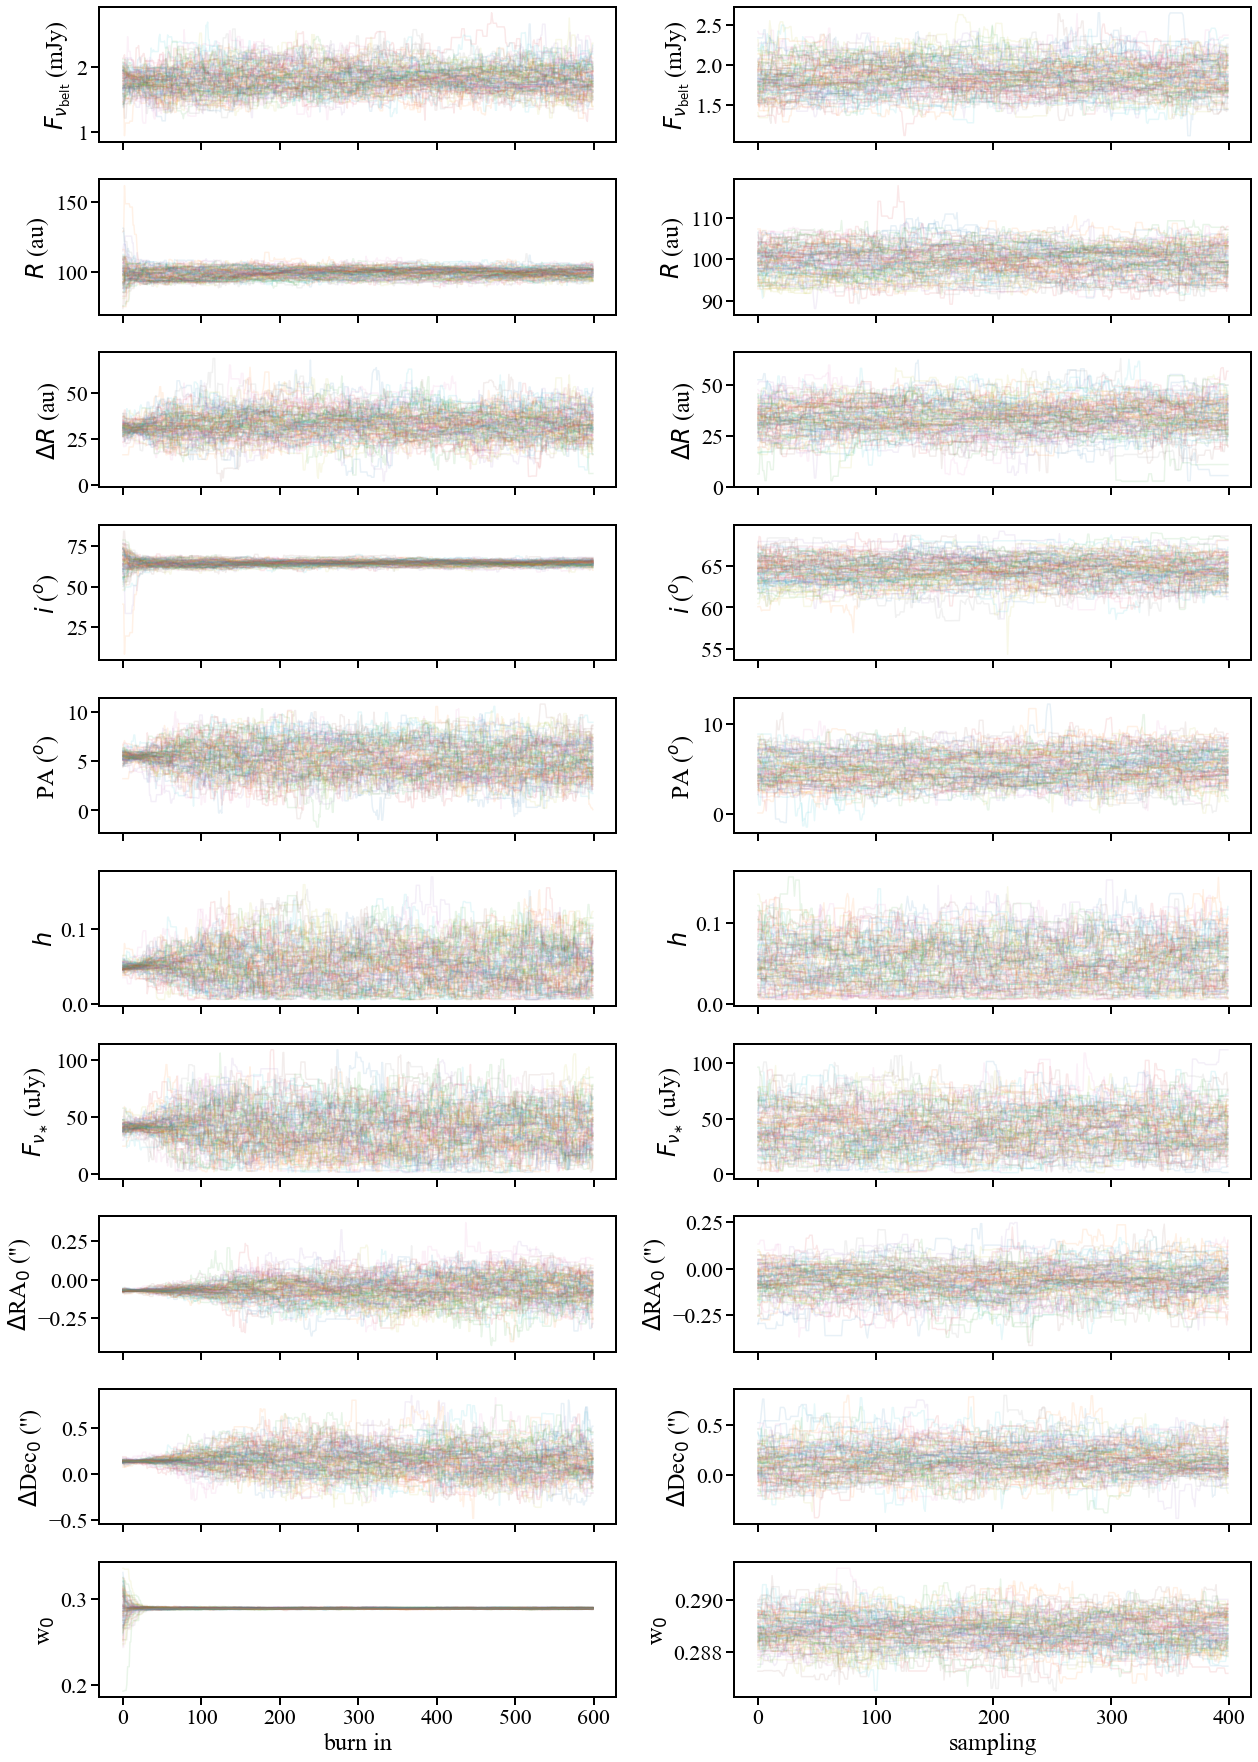

/d1/boudica1/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:125: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


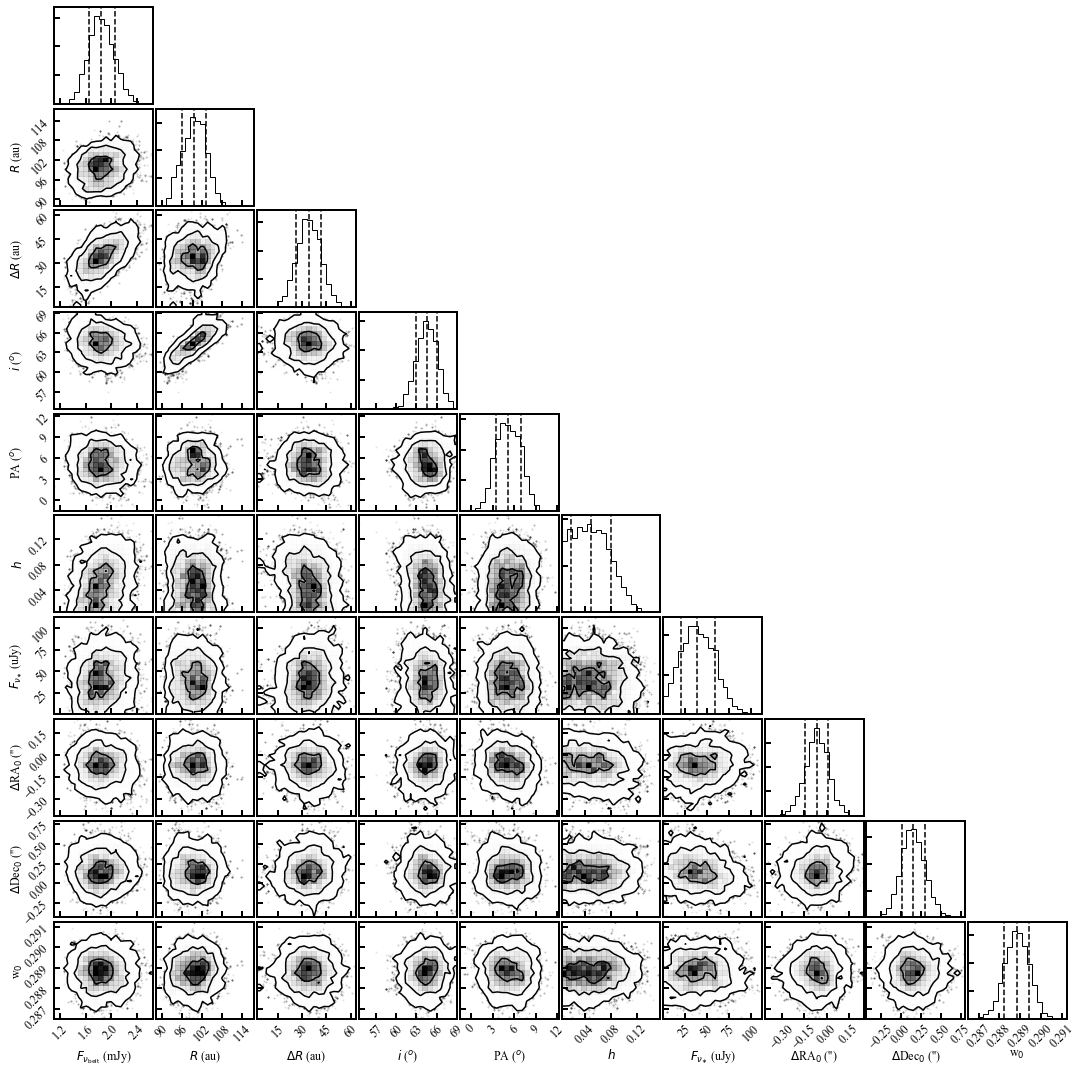

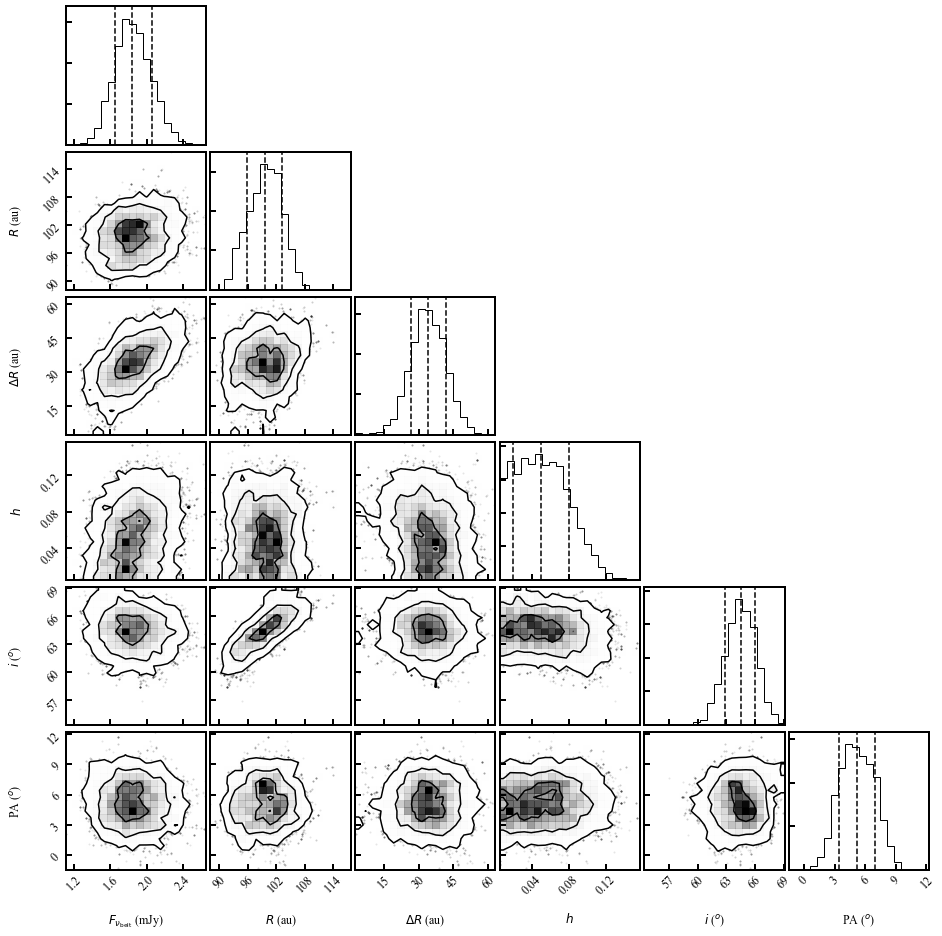

In [4]:
burnin=600

cornername='./evaluation/triangle_'+sourcetag+'_cont'
traceplotname='./evaluation/traceplot_'+sourcetag+'_cont'

%run -i maketraceandcornerplot.py

Now figure out best-fit parameters and upper and lower 1sigma boundaries for every parameter. <br>
These are taken, respectively, as the 50th, 16th, and 84th percentiles of the distributions - which is only good if the
distributions look single- and centrally peaked. If not, it's up to you to modify the values and report parameters as lower or upper limits in your paper!

In [5]:
pbest=list(map(lambda v: (v[1]), zip(*np.percentile(samples, [16,50,84], axis=0))))
pbest1up=list(map(lambda v: (v[2]), zip(*np.percentile(samples, [16,50,84], axis=0))))
pbest1dwn=list(map(lambda v: (v[0]), zip(*np.percentile(samples, [16,50,84], axis=0))))
for i in np.arange(len(pbest)):
    print(labelparams[i],"{:.4f}".format(pbest[i]), "+{:.4f}".format(pbest1up[i]-pbest[i]), "-{:.4f}".format(pbest[i]-pbest1dwn[i]))


$F_{\nu_{\rm belt}}$ (mJy) 1.8427 +0.2132 -0.1901
$R$ (au) 99.7305 +3.4474 -3.8547
$\Delta R$ (au) 34.0885 +7.6322 -7.4914
$i$ ($^{o}$) 64.5256 +1.5301 -1.6040
PA ($^{o}$) 5.1594 +1.8420 -1.7173
$h$ 0.0494 +0.0310 -0.0296
$F_{\nu_{\ast}}$ (uJy) 39.2357 +20.4923 -18.5134
$\Delta$RA$_0$ ('') -0.0649 +0.0759 -0.0788
$\Delta$Dec$_0$ ('') 0.1430 +0.1547 -0.1379
w$_0$ 0.2888 +0.0006 -0.0006


(Re-)Produce best-fit model image and visibilities given best fit parameters, quick-check and save image

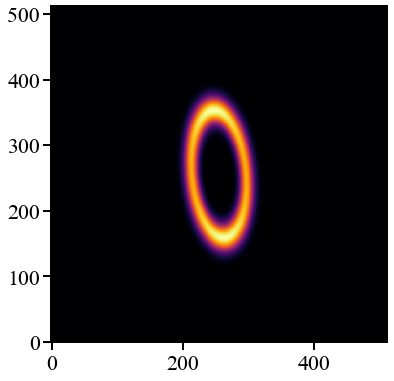

In [52]:
#First turn back to native units from plotting units
pbestformodel=np.asarray(pbest).copy()
pbestformodel[[x for x in range(len(labels)) if labels[x]=='fnu'][0]]/=1e3
pbestformodel[[x for x in range(len(labels)) if labels[x]=='fnustar'][0]]/=1e6
pbestformodel[[x for x in range(len(labels)) if labels[x]=='r'][0]]/=dist
pbestformodel[[x for x in range(len(labels)) if labels[x]=='sigr'][0]]/=dist*2.0*np.sqrt(2.0*np.log(2.0))
if pachange:
    pbestformodel[[x for x in range(len(labels)) if labels[x]=='pa'][0]]-=180.0
#Recreate image, obtain model's log-likelihood
locmodelvis='./evaluation'
modelim, pxsz, lnL = lnpostfn(pbestformodel, locmodelvis)
#Quick check of model image
pl.figure(figsize=(6,6))
pl.imshow(modelim, origin='lower', cmap='inferno')
#Save best-fit model image, and its pixel size, for later plotting
np.save('./evaluation/'+sourcetag+'_material_modelim.npy', [modelim, pxsz])

Now make deprojected real and imaginary visibility plots with data vs model. <br>
Remember to define your plot parameters appropriately below.

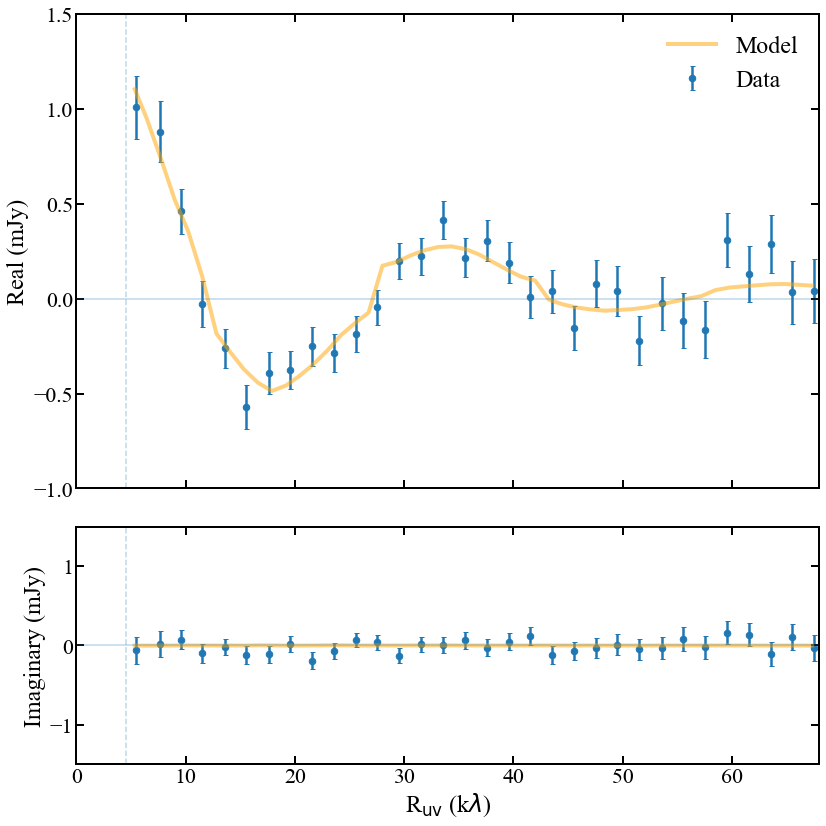

In [54]:
#Import routine
import makeuvdeprojplot_simple_multiple
import importlib
importlib.reload(makeuvdeprojplot_simple_multiple)
#Set weight factor for proper error bars
warr=np.load('./evaluation/warr.npy')

#Provide location of visibilities for data, model, PA, inc and best-fit offset parameters for each dataset (which we will use
#to realign datasets). Normally you should NOT need to change these locations as they are standardised
datavisloc=['../calibratedms/'+vis[i][:-3]+'.npy' for i in np.arange(nvis)]
modelvisloc=[locmodelvis+'/'+sourcetag+'_uvtable_model'+str(i)+'.npy' for i in np.arange(nvis)]
paradoffsetloc=[locmodelvis+'/bestfitshiftPAinc_rad'+str(i)+'.npy' for i in np.arange(nvis)]

#Do you want to phase shift data, model and residual datasets so star+disk are centered at the phase center of 
#each observation? NOTE: if observation is a mosaic, and offsets are defined with respect to the star (rather than
#each pointing center) this should be turned OFF.
phaseshift=True

#Maximum u-v distance to plot
uvmax=68.e3
#Bin size of u-v bins
uvbin_size=2e3
#Lower and upper limit of Real part plot
ylimreal=[-1,1.5] #Limits on y axis in mJy
#Lower and upper limit of Imaginary part plot
ylimimag=[-1.5,1.5] #Limits on y axis in mJy
#Name of output plot
outfile='./evaluation/'+sourcetag+'_deprojvis.pdf'

#Execute plot.
uvbins, uvbins_mod, bin_re, bin_re_err, bin_re_modfine, bin_im, bin_im_err, bin_im_modfine = makeuvdeprojplot_simple_multiple.makeuvdeprojplot(datavisloc, modelvisloc, paradoffsetloc, uvmax, uvbin_size, warr, ylimreal, ylimimag, outfile, sourcetag, phaseshift)
#Save output for later plotting.
np.save('./evaluation/'+tag+'_material_uvplot.npy', [uvbins, uvbins_mod, bin_re, bin_re_err, bin_re_modfine, bin_im, bin_im_err, bin_im_modfine, ylimreal, ylimimag, uvmax])

And finally, use CASA to produce model (noiseless) and residual MS files and dirty images. <br>
Additionally, produce a reweighted and phase shifted dataset - this may improve the original imaging particularly if you
had multiple datasets with wildly different weight rescaling factors, and with large spatial offsets from the phase 
center.